### This notebook is not updated, check SIR model to get the latest updates about data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import multiprocessing as mp
import pickle
from datetime import date
import matplotlib.dates as mdates
import requests
import json
import os
from datetime import date
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp,odeint
import scipy.stats as st

For this compartmental model, we choose to fit the parameters on the data on confirmed cases provided by the Italian Protezione Civile deposited in this repository: https://github.com/pcm-dpc/COVID-19/raw/master/dati-json/

In [2]:
today=date.today()

In [3]:
datafilename='country'+today.strftime("%Y_%m_%d")+'.json'
url='https://github.com/pcm-dpc/COVID-19/raw/master/dati-json/dpc-covid19-ita-andamento-nazionale.json'
response = requests.get(url)
#with open( 'data/PC/'+datafilename, 'w') as f:
#    json.dump(response.json(),f)

In [22]:
with open('data/PC/'+datafilename,'r') as f:
    data_file=json.load(f)
data=pd.DataFrame()
for p in data_file:
    data.loc[p['data'],'Hospitalized']=p['totale_ospedalizzati']
    data.loc[p['data'],'Confirmed_cases']=p['totale_attualmente_positivi']
    data.loc[p['data'],'Deaths']=p['deceduti']
    data.loc[p['data'],'Recovered']=p['dimessi_guariti']
data.index=pd.to_datetime(data.index)
data['Removed']=data['Deaths']+data['Recovered']

#population=60480000.
population=20000000
# Start of the study (can be modified as wanted)
#start = today-pd.DateOffset(days=20)
start=pd.to_datetime('2020-02-24 18:00:00')
end = data.index.max()
print('Data updated to: ',str(end))
days=(end-start).days+1
t = np.linspace(start.value, end.value, days)
t = pd.to_datetime(t)
tempo=np.linspace(1,days,days,dtype=int)


Data updated to:  2020-03-30 17:00:00


The model we choose is a Susceptible-Exposed-Infected-Removed (SEIR).  
We specify thaht R0 is not directly a parameter of the model, but you can derive it from other model parameters. Since R0 has the easy-to-say meaning of "secundary cases from a single infected person", it is very popular during this outbreak, and it is very useful to describe the behaviour of the epidemiological curves. In particular, if R0 > 1, the number of infected people increase exponentially without slow-downs. If R0<1, the exponential growth of the outbreak's size does not increase forever and begins to decrease after a single peak. (https://www.icts.res.in/sites/default/files/PuneR0talk.pdf)

In the next chunk, we initialize the parameter we know from literature about COVID-19 (reference will be provided). We also set up some values as a starting point for the fit of the parameters we do not know the value of.

In [23]:
#Known parameters
days_to_recover=4
mur=1/days_to_recover
#days_to_die=15
#mud=1/days_to_die
gamma=mur


#initial guess for parameters to fit from data
days_to_infect=3
alpha=1/days_to_infect
R0=2.5
beta=gamma*R0
print('Initial parameters:\n beta={:.3f} gamma={:.3f} alpha={:.3f}'.format(beta,gamma,alpha))

Initial parameters:
 beta=0.625 gamma=0.250 alpha=0.333


The number of confirmed case is known, but it is almost certain that the number of real infected people is much higher than the number of confirmed cases. At an early stage of the epidemic, howerver, we assume the numbe of initial infected people to be the number of confirmed cases.

Similarly, we assume $E_i$, the initial number of exposed, to be equal to the secondary cases generated from infected individual ($E_i=R_0 * I_i$).

In [24]:
I_i=data[data.index==start]['Confirmed_cases'].iloc[0]
R_i=data[data.index==start]['Removed'].iloc[0]
E_i=I_i*R0
N=population
x0=[N-E_i-I_i-R_i,E_i,I_i,R_i]
print('\nInitial conditions:\n S={:.0f},E={:.0f},I={:.0f},R={:.0f}'.format(x0[0],x0[1],x0[2],x0[3]))


Initial conditions:
 S=19999218,E=552,I=221,R=8


### Fitting parameters

In [20]:
def SEIR_ode(t,x,beta,alpha,gamma):
        S,E,I,R=x
        dS=-beta*S*I/N
        dE=beta*S*I/N-alpha*E
        dI=alpha*E-gamma*I
        dR=gamma*I
        return [dS,dE,dI,dR]
    
def SEIRinteg(ti,beta,alpha,gamma):
    #I0,beta,mu=p
    #print(t)
    x0=[N-E_i-I_i-R_i,E_i,I_i,R_i]   
    sol=solve_ivp(SEIR_ode,[0,days],x0,args=(beta,alpha,gamma),
                  t_eval=np.arange(0,days+1,1))
    lung=len(sol.y[0])
    #print(sol.y[1].reshape(1,25).shape)
    #print(np.concatenate((sol.y[1].reshape(1,25),sol.y[2].reshape(1,25)),axis=0).shape)
    #print(np.concatenate((sol.y[1].reshape(25,1),sol.y[2].reshape(25,1)),axis=1).shape)
    #print(sol.y[1][ti])
    #print(sol.y[1].shape)
    #return sol.y[3]
    #return np.concatenate((sol.y[1].reshape(1,25),sol.y[2].reshape(1,25)),axis=0)
    return np.concatenate((sol.y[2].reshape(lung,1),sol.y[3].reshape(lung,1)),axis=1).flatten()
    #return np.array([sol.y[1][t],sol.y[2][t]])
    
popt, pcov = curve_fit(SEIRinteg, tempo, 
                       np.array(data.loc[start:,['Confirmed_cases','Removed']].values).flatten(),
                       p0=[beta,alpha,gamma])
#I0=popt[0]
beta=popt[0]
alpha=popt[1]
gamma=popt[2]
R0=beta/gamma
#print('\nFitted parameters:\nI0= ',I0)
print('beta:',beta,' , alpha={}, gamma: {}'.format(alpha,gamma))
print('R0:',R0,' , days to be removed: {}'.format(1/gamma))
print('days to become infective:{}'.format(1/alpha))

beta: 0.18273612578545126  , alpha=28.126767353940295, gamma: 0.04335090309507463
R0: 4.215278408034204  , days to be removed: 23.067570191256667
days to become infective:0.03555332141146001


In [21]:
#x0=[N-E_i-I_i-R_i,E_i,I_i,R_i]
integ=solve_ivp(SEIR_ode,[0,days],x0,args=(beta,alpha,gamma),t_eval=tempo)
res=pd.DataFrame()
res['Susceptible']=integ.y[0]
res['Exposed']=integ.y[1]
res['Infected']=integ.y[2]
res['Removed']=integ.y[3]
res['Step']=tempo
res['Day']=t

[None, None]

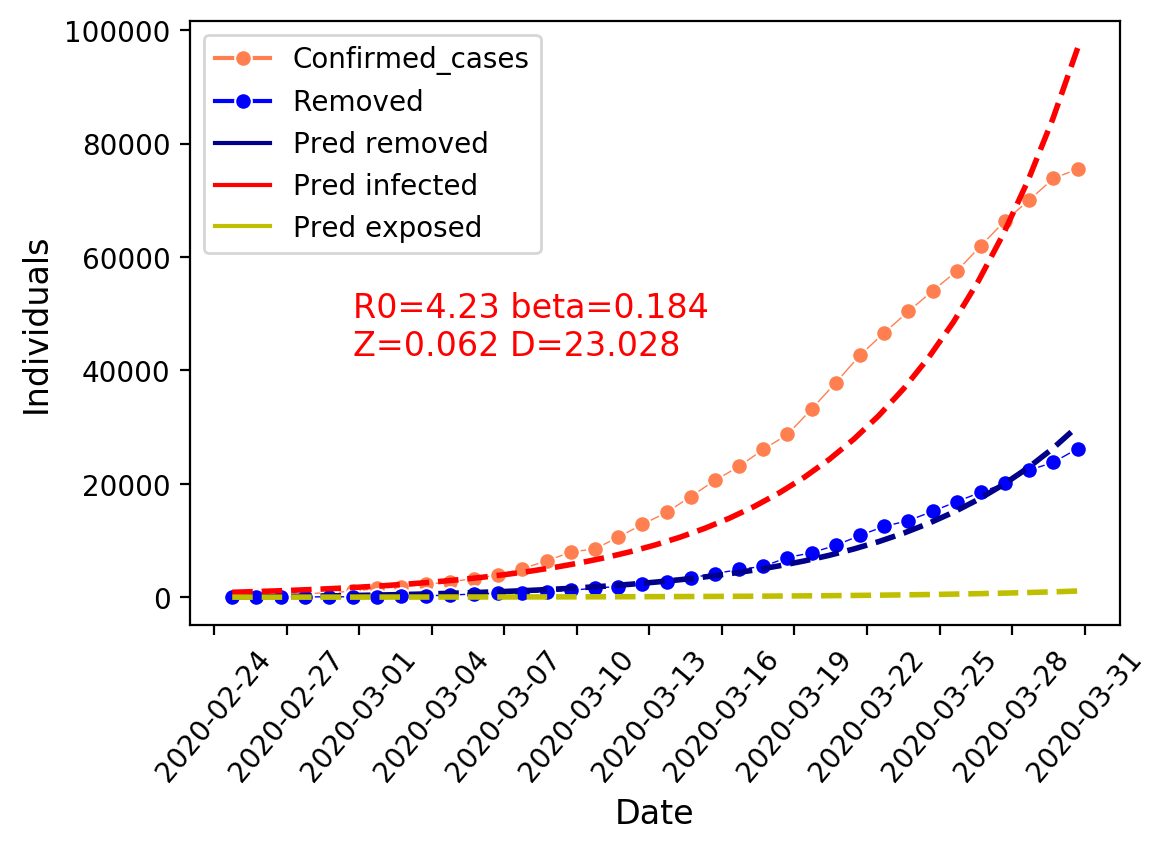

In [87]:
inf_col='Confirmed_cases'

f,ax=plt.subplots(1,1,dpi=200)
sns.lineplot(x=data.index,y=inf_col,data=data,marker='o',ax=ax,
             label=inf_col,color='coral')
sns.lineplot(x=data.index,y='Removed',data=data,marker='o',ax=ax,
             label='Removed',color='blue')

def phi(d, precision=30): 
    x = 2.00
    for i in range(precision): 
        x = pow(1+x,1/(d+1)) 
    return x

def gaussian_icdf(q):
    return st.norm.isf(q)

def identity(x):
    return x

def a_generate(ndim, Npoints, *, seed=721, mapper=identity):
    # get the base for the dimension
    g = phi(ndim) 
    # this is the inizialization constant for the array
    alpha = ((1/g)**np.arange(1, ndim+1))%1  
    # reshaping to allow broadcasting
    alpha = alpha.reshape(1, -1) 
    # just the count of the sequence
    base = np.arange(Npoints).reshape(-1, 1) 
    # perform the actual calculation
    z = seed + alpha*base 
    # tale only the decimal part
    z = z % 1
    # return a mapped version to some distribution
    return mapper(z)

class mapper_multivariate_normal:
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov
        # we have to use the cholesky decomposition to generate the samples
        self.L = np.linalg.cholesky(cov)
        
    def __call__(self, quantiles):
        values_standard = st.norm.isf(quantiles)
        values =  self.L @ values_standard.reshape(len(self.L), -1)
        values = values + self.mean.reshape(len(self.L), -1)
        return values.T
    
mapper = mapper_multivariate_normal(mean=popt, cov=pcov)
p_seq = a_generate(3, 500, mapper=mapper)
#x_base = np.linspace(0, 10, 51)

#for params in p_seq:
 #   if sum(params)<np.inf and all(p>0 for p in params):
  #      #print(params)
   #     y_hat = solve_ivp(SEIR_ode,[0,days],x0,args=(params),t_eval=tempo)
    #    sns.lineplot(x=res.Day,y=y_hat.y[3],ax=ax,
     #                #label='beta={:1.2f} mu={:1.2f}'.format(params[0],params[1]),
      #               color='teal',alpha=0.2)
    
sns.lineplot(x='Day',y='Removed',data=res,ax=ax,label='Pred removed',color='darkblue')
sns.lineplot(x='Day',y='Infected',data=res,ax=ax,label='Pred infected',color='r')
sns.lineplot(x='Day',y='Exposed',data=res,ax=ax,label='Pred exposed',color='y')

plt.setp(ax.lines,linewidth=0.5)
plt.setp(ax.lines[-1],linewidth=2)
plt.setp(ax.lines[-2],linewidth=2)
plt.setp(ax.lines[-3],linewidth=2)
ax.lines[-1].set_linestyle("--")
ax.lines[-2].set_linestyle("--")
ax.lines[-3].set_linestyle("--")
ax.set_xlabel('Date',fontsize=12)
ax.set_ylabel('Individuals',fontsize=12)
plt.annotate('R0={:1.2f} beta={:1.3f}\nZ={:1.3f} D={:1.3f}'.format(R0,beta,1/alpha,1/gamma),
             xy=(mdates.date2num(data.index[5]), data[inf_col][-10]),
             fontsize=12,color='r')
#plt.yscale('log')
#ax.set_xlim(pd.to_datetime('2020-02-15'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=50,fontsize=10 )
plt.setp( ax.yaxis.get_majorticklabels(), fontsize=10 )
plt.setp(ax.get_legend().get_texts(), fontsize='10') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title

### Fitting initial conditions

In [25]:
def SEIR_ode(t,x,beta,alpha,gamma):
        S,E,I,R=x
        dS=-beta*S*I/N
        dE=beta*S*I/N-alpha*E
        dI=alpha*E-gamma*I
        dR=gamma*I
        return [dS,dE,dI,dR]
    
def SEIRinteg(ti,beta,alpha,gamma,E_i):
    #I0,beta,mu=p
    #print(t)
    x0=[N-E_i-I_i-R_i,E_i,I_i,R_i]   
    sol=solve_ivp(SEIR_ode,[0,days],x0,args=(beta,alpha,gamma),
                  t_eval=np.arange(0,days+1,1))
    lung=len(sol.y[0])
    #print(sol.y[1].reshape(1,25).shape)
    #print(np.concatenate((sol.y[1].reshape(1,25),sol.y[2].reshape(1,25)),axis=0).shape)
    #print(np.concatenate((sol.y[1].reshape(25,1),sol.y[2].reshape(25,1)),axis=1).shape)
    #print(sol.y[1][ti])
    #print(sol.y[1].shape)
    #return sol.y[3]
    #return np.concatenate((sol.y[1].reshape(1,25),sol.y[2].reshape(1,25)),axis=0)
    return np.concatenate((sol.y[2].reshape(lung,1),sol.y[3].reshape(lung,1)),axis=1).flatten()
    #return np.array([sol.y[1][t],sol.y[2][t]])
    
popt, pcov = curve_fit(SEIRinteg, tempo, 
                       np.array(data.loc[start:,['Confirmed_cases','Removed']].values).flatten(),
                       p0=[beta,alpha,gamma,E_i],maxfev=10000)
#I0=popt[0]
beta=popt[0]
alpha=popt[1]
gamma=popt[2]
E_i=popt[3]
x0=[N-E_i-I_i-R_i,E_i,I_i,R_i]
R0=beta/gamma
#print('\nFitted parameters:\nI0= ',I0)
print('beta:',beta,' , alpha={}, gamma: {}'.format(alpha,gamma))
print('R0:',R0,' , days to be removed: {}'.format(1/gamma))
print('days to become infective:{}'.format(1/alpha))
print('Init exposed Ei={}'.format(int(E_i)))

beta: 153.6298748647654  , alpha=0.0003010477314497664, gamma: 0.03282128925855306
R0: 4680.799515659802  , days to be removed: 30.468029214891526
days to become infective:3321.7323883633467
Init exposed Ei=594442


In [26]:
x0=[N-E_i-I_i-R_i,E_i,I_i,R_i]
integ=solve_ivp(SEIR_ode,[0,days],x0,args=(beta,alpha,gamma),t_eval=tempo)
res=pd.DataFrame()
res['Susceptible']=integ.y[0]
res['Exposed']=integ.y[1]
res['Infected']=integ.y[2]
res['Removed']=integ.y[3]
res['Step']=tempo
res['Day']=t
print('\nInitial conditions:\n S={:.0f},E={:.0f},I={:.0f},R={:.0f}'.format(x0[0],x0[1],x0[2],x0[3]))


Initial conditions:
 S=19405329,E=594442,I=221,R=8


[None, None]

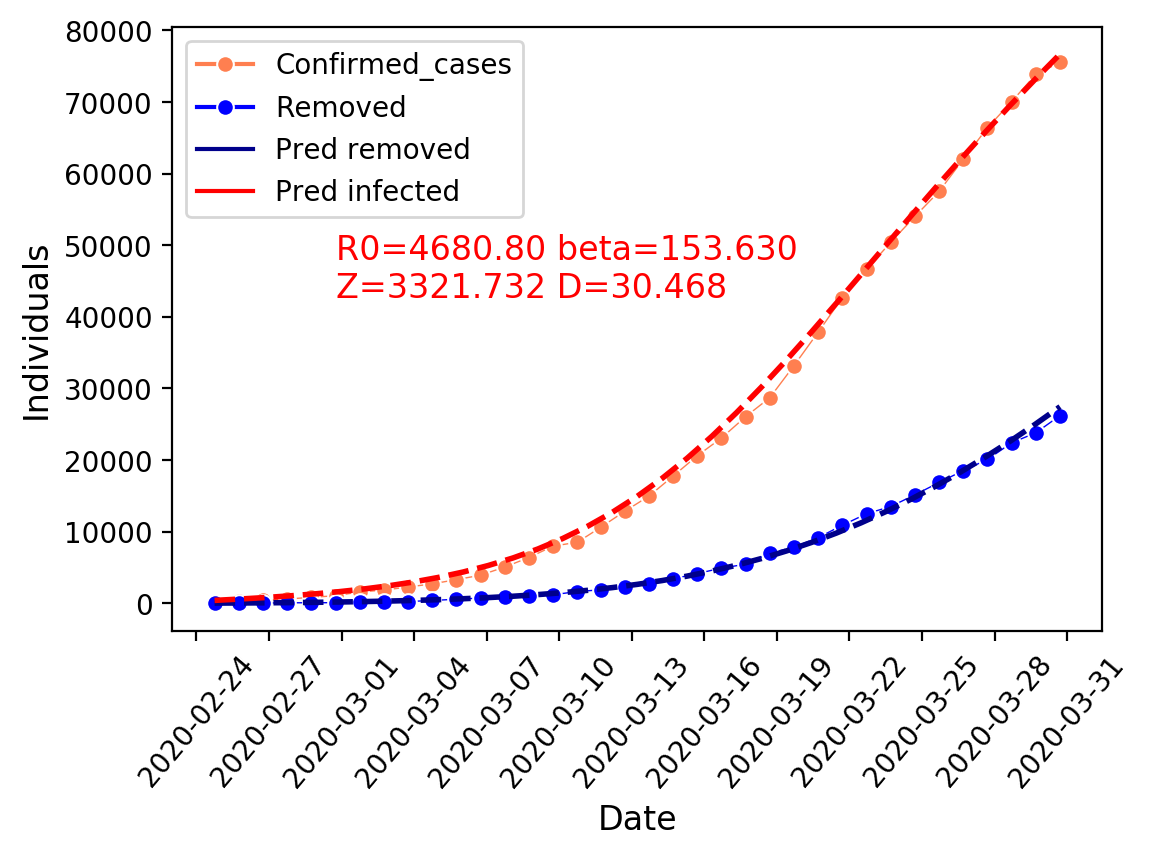

In [28]:
inf_col='Confirmed_cases'

f,ax=plt.subplots(1,1,dpi=200)
sns.lineplot(x=data.index,y=inf_col,data=data,marker='o',ax=ax,
             label=inf_col,color='coral')
sns.lineplot(x=data.index,y='Removed',data=data,marker='o',ax=ax,
             label='Removed',color='blue')

def phi(d, precision=30): 
    x = 2.00
    for i in range(precision): 
        x = pow(1+x,1/(d+1)) 
    return x

def gaussian_icdf(q):
    return st.norm.isf(q)

def identity(x):
    return x

def a_generate(ndim, Npoints, *, seed=721, mapper=identity):
    # get the base for the dimension
    g = phi(ndim) 
    # this is the inizialization constant for the array
    alpha = ((1/g)**np.arange(1, ndim+1))%1  
    # reshaping to allow broadcasting
    alpha = alpha.reshape(1, -1) 
    # just the count of the sequence
    base = np.arange(Npoints).reshape(-1, 1) 
    # perform the actual calculation
    z = seed + alpha*base 
    # tale only the decimal part
    z = z % 1
    # return a mapped version to some distribution
    return mapper(z)

class mapper_multivariate_normal:
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov
        # we have to use the cholesky decomposition to generate the samples
        self.L = np.linalg.cholesky(cov)
        
    def __call__(self, quantiles):
        values_standard = st.norm.isf(quantiles)
        values =  self.L @ values_standard.reshape(len(self.L), -1)
        values = values + self.mean.reshape(len(self.L), -1)
        return values.T
    
mapper = mapper_multivariate_normal(mean=popt, cov=pcov)
p_seq = a_generate(3, 500, mapper=mapper)
#x_base = np.linspace(0, 10, 51)

#for params in p_seq:
 #   if sum(params)<np.inf and all(p>0 for p in params):
  #      #print(params)
   #     y_hat = solve_ivp(SEIR_ode,[0,days],x0,args=(params),t_eval=tempo)
    #    sns.lineplot(x=res.Day,y=y_hat.y[3],ax=ax,
     #                #label='beta={:1.2f} mu={:1.2f}'.format(params[0],params[1]),
      #               color='teal',alpha=0.2)
    
sns.lineplot(x='Day',y='Removed',data=res,ax=ax,label='Pred removed',color='darkblue')
sns.lineplot(x='Day',y='Infected',data=res,ax=ax,label='Pred infected',color='r')
#sns.lineplot(x='Day',y='Exposed',data=res,ax=ax,label='Pred exposed',color='y')

plt.setp(ax.lines,linewidth=0.5)
plt.setp(ax.lines[2],linewidth=2)
plt.setp(ax.lines[3],linewidth=2)
#plt.setp(ax.lines[4],linewidth=2)
ax.lines[2].set_linestyle("--")
ax.lines[3].set_linestyle("--")
#ax.lines[4].set_linestyle("--")
ax.set_xlabel('Date',fontsize=12)
ax.set_ylabel('Individuals',fontsize=12)
plt.annotate('R0={:1.2f} beta={:1.3f}\nZ={:1.3f} D={:1.3f}'.format(R0,beta,1/alpha,1/gamma),
             xy=(mdates.date2num(data.index[5]), data[inf_col][-10]),
             fontsize=12,color='r')
#plt.yscale('log')
#ax.set_xlim(pd.to_datetime('2020-02-15'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=50,fontsize=10 )
plt.setp( ax.yaxis.get_majorticklabels(), fontsize=10 )
plt.setp(ax.get_legend().get_texts(), fontsize='10') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title